In [1]:
import pandas as pd
import cv2
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.layers import Dense, Conv2D, Input, AveragePooling2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Conv2DTranspose
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import re
import plotly.express as px
from keras.callbacks import EarlyStopping
from scipy import stats
from tqdm import tqdm
from keras.callbacks import EarlyStopping
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.get_logger().setLevel('INFO')

Num GPUs Available:  1


Dataset: https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset

# Análisis exploratorio

In [3]:
df = pd.read_csv('archive/metadata.csv')
df.head()

Unnamed: 0            image  class format mode          shape
0           0   Cancer (1).jpg  tumor   JPEG  RGB  (512, 512, 3)
1           1   Cancer (1).png  tumor    PNG    L     (300, 240)
2           2   Cancer (1).tif  tumor   TIFF  RGB  (256, 256, 3)
3           3  Cancer (10).jpg  tumor   JPEG  RGB  (512, 512, 3)
4           4  Cancer (10).tif  tumor   TIFF  RGB  (256, 256, 3)

## Limpieza del dataset

In [4]:
def str2list(string):
    return re.sub(r"[\(\)]", "", string).split(",")

In [5]:
df["shape"] = df["shape"].apply(str2list)

In [6]:
shapes = pd.DataFrame(df["shape"].to_list(), columns=['width', 'height', "channels"])
shapes = shapes.fillna(1)
shapes = shapes.astype("int32")

In [7]:
for shape in ["width", "height", "channels"]:
    df[shape] = shapes[shape]
df = df.drop(['Unnamed: 0', "shape"], axis=1)
df

image   class format mode  width  height  channels
0            Cancer (1).jpg   tumor   JPEG  RGB    512     512         3
1            Cancer (1).png   tumor    PNG    L    300     240         1
2            Cancer (1).tif   tumor   TIFF  RGB    256     256         3
3           Cancer (10).jpg   tumor   JPEG  RGB    512     512         3
4           Cancer (10).tif   tumor   TIFF  RGB    256     256         3
...                     ...     ...    ...  ...    ...     ...       ...
4595  Not Cancer  (995).jpg  normal   JPEG  RGB    168     300         3
4596  Not Cancer  (996).jpg  normal   JPEG  RGB    509     452         3
4597  Not Cancer  (997).jpg  normal   JPEG  RGB    197     177         3
4598  Not Cancer  (998).jpg  normal   JPEG  RGB    217     232         3
4599  Not Cancer  (999).jpg  normal   JPEG  RGB    221     228         3

[4600 rows x 7 columns]

In [8]:
df.shape

(4600, 7)

In [9]:
df["class"].value_counts()

tumor     2513
normal    2087
Name: class, dtype: int64

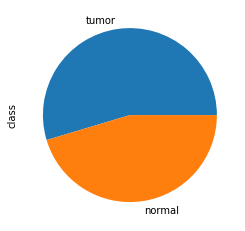

In [10]:
df['class'].value_counts().plot.pie();

In [11]:
df["mode"].unique()

array(['RGB', 'L', 'RGBA', 'P'], dtype=object)

In [12]:
df[df["mode"]=="P"]

image   class format mode  width  height  channels
4129  Not Cancer  (576).jpg  normal    PNG    P    725     728         1
4581  Not Cancer  (982).jpg  normal    PNG    P    725     728         1

In [13]:
df[df["mode"]=="L"]

image   class format mode  width  height  channels
1            Cancer (1).png   tumor    PNG    L    300     240         1
36        Cancer (1028).jpg   tumor   JPEG    L    336     300         1
239       Cancer (1209).jpg   tumor   JPEG    L    336     300         1
269       Cancer (1236).jpg   tumor   JPEG    L   1024    1024         1
293       Cancer (1258).jpg   tumor   JPEG    L   1427    1275         1
...                     ...     ...    ...  ...    ...     ...       ...
4561  Not Cancer  (964).jpg  normal   JPEG    L    225     225         1
4566  Not Cancer  (969).jpg  normal   JPEG    L   1024    1024         1
4571  Not Cancer  (973).jpg  normal   JPEG    L    275     220         1
4577  Not Cancer  (979).jpg  normal   JPEG    L    301     275         1
4583  Not Cancer  (984).jpg  normal   JPEG    L    442     409         1

[132 rows x 7 columns]

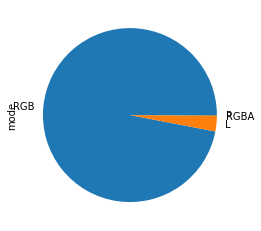

In [14]:
df['mode'].value_counts().plot.pie();

In [15]:
fig = px.box(df, y=["width", "height"], title="Dimensiones de las imagenes")
fig.show()

In [16]:
df[df["height"] < 927].describe()

width       height     channels
count  4549.000000  4549.000000  4549.000000
mean    370.018246   350.834469     2.951858
std     153.598454   154.242167     0.311907
min     167.000000   150.000000     1.000000
25%     236.000000   225.000000     3.000000
50%     337.000000   283.000000     3.000000
75%     512.000000   512.000000     3.000000
max    1075.000000   926.000000     4.000000

# Preprocesamiento

In [17]:
casos = [1586,
2376,
2373,
2326,
184,
1016,
10,
1197,
1469]

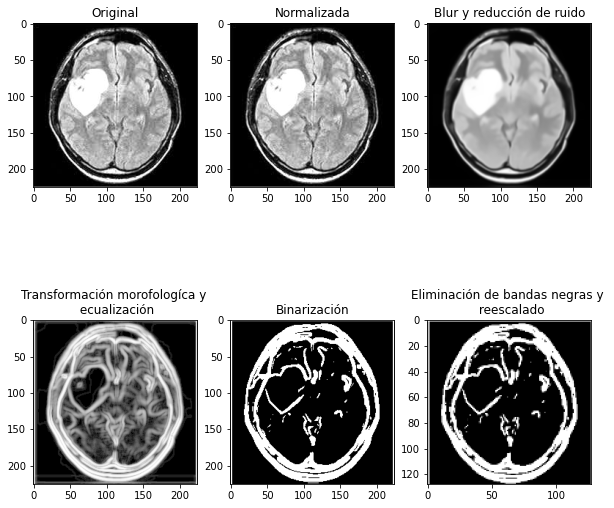

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

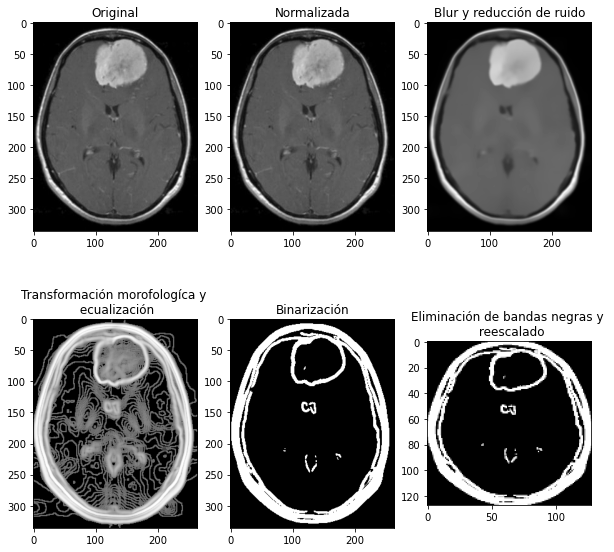

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

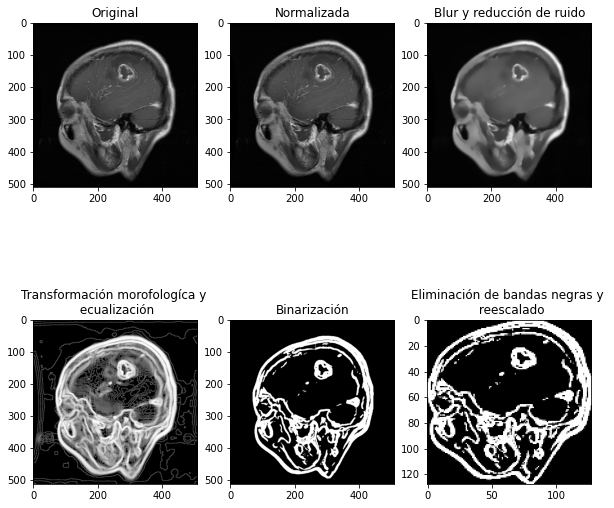

<Figure size 432x288 with 0 Axes>

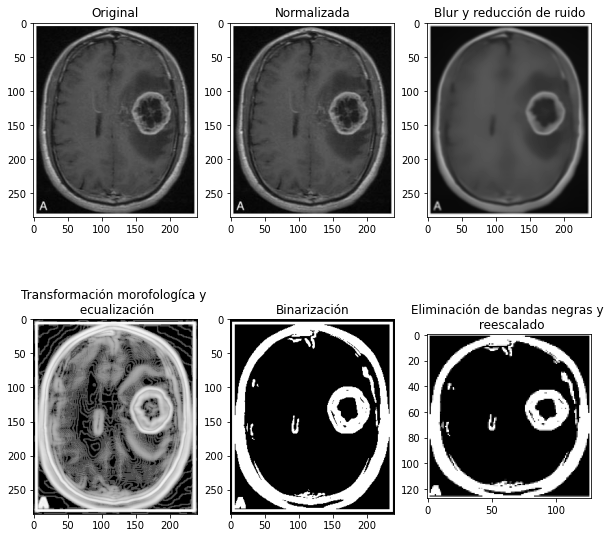

<Figure size 432x288 with 0 Axes>

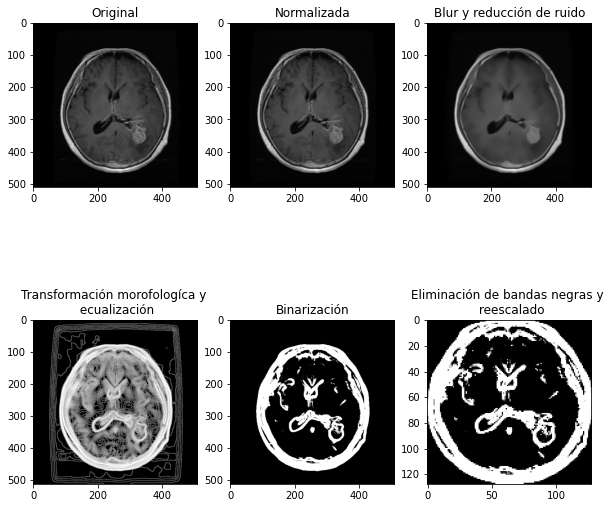

<Figure size 432x288 with 0 Axes>

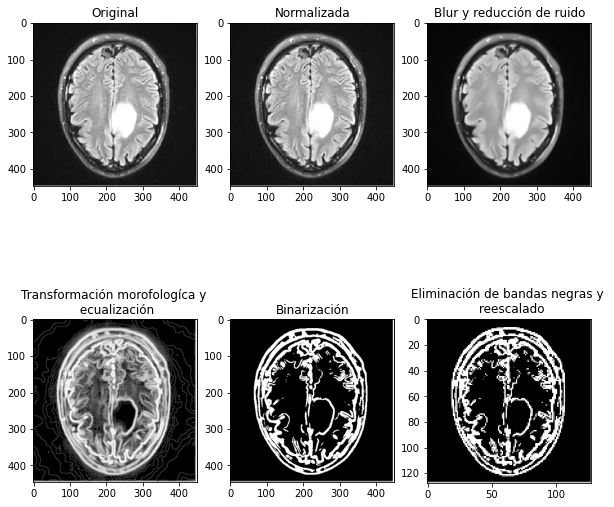

<Figure size 432x288 with 0 Axes>

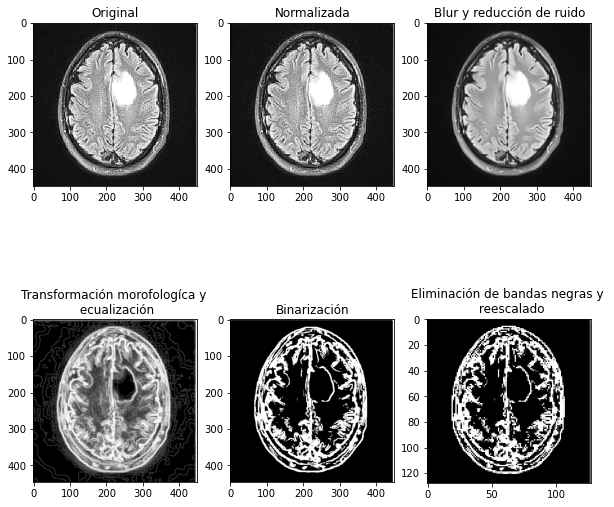

<Figure size 432x288 with 0 Axes>

In [23]:
for i in casos:
    img = cv2.imread("archive/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer ("+ str(i) + ").jpg", 0)
    fig, ax = plt.subplots(2, 3, figsize=(10,10))
    ax[0][0].imshow(img, cmap="gray")
    ax[0][0].set_title("Original")

    img2 = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX)
    ax[0][1].imshow(img2, cmap="gray")
    ax[0][1].set_title("Normalizada")


    img2 = cv2.blur(img2, (3, 3))
    img2 = cv2.fastNlMeansDenoising(img2, None, 20, 7, 21) 


    ax[0][2].imshow(img2, cmap="gray")
    ax[0][2].set_title("Blur y reducción de ruido")

    kernel = np.ones((3, 3), np.uint8)
    img2 = cv2.morphologyEx(img2, cv2.MORPH_GRADIENT, kernel)
    img2 = cv2.equalizeHist(img2)

    ax[1][0].imshow(img2, cmap="gray")
    ax[1][0].set_title("Transformación morofologíca y \n ecualización")
    img2 = np.where(img2 > 150, img2, 0)
    #img2 = cv2.fastNlMeansDenoising(img2, None, 20, 7, 21) 
    
    
    img2 = cv2.threshold(img2, 170, 255, cv2.THRESH_BINARY)[1]
    ax[1][1].imshow(img2, cmap="gray")
    ax[1][1].set_title("Binarización")

    y_nonzero, x_nonzero = np.nonzero(img2)
    img2 = img2[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]
    img2 = cv2.resize(img2, (128, 128))
    ax[1][2].imshow(img2, cmap="gray")
    ax[1][2].set_title("Eliminación de bandas negras y \n reescalado")
    plt.figure()


In [ ]:
img = cv2.imread("archive/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).tif", 0)
fig, ax = plt.subplots(2, 3, figsize=(10,10))
ax[0][0].imshow(img, cmap="gray")
ax[0][0].set_title("Original")

img2 = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX)
ax[0][1].imshow(img2, cmap="gray")
ax[0][1].set_title("Normalizada")


img2 = cv2.blur(img2, (3, 3))
img2 = cv2.fastNlMeansDenoising(img2, None, 20, 7, 21) 


ax[0][2].imshow(img2, cmap="gray")
ax[0][2].set_title("Ecualizada")

hist = cv2.calcHist([img2],[0],None,[255],[0,256])
#if np.argmax(hist[100:])+100 < 150:
kernel = np.ones((3, 3), np.uint8)
img2 = cv2.morphologyEx(img2, cv2.MORPH_GRADIENT, kernel)
img2 = cv2.equalizeHist(img2)

ax[1][0].imshow(img2, cmap="gray")
ax[1][0].set_title("Eliminación de ruido")

img2 = cv2.threshold(img2, 180, 255, cv2.THRESH_BINARY)[1]
ax[1][1].imshow(img2, cmap="gray")
ax[1][1].set_title("Binarización")

y_nonzero, x_nonzero = np.nonzero(img2)
img2 = img2[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]
img2 = cv2.resize(img2, (128, 128))
ax[1][2].imshow(img2, cmap="gray")
ax[1][2].set_title("Eliminación de bandas negras")
plt.figure()

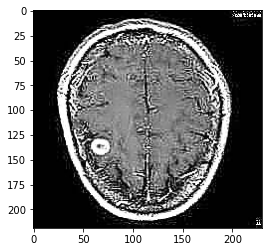

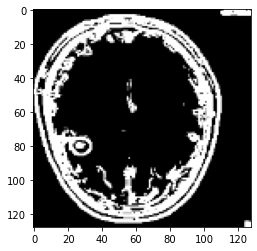

In [24]:
def preprocessing(img, kernel):
    img = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX)
    img = cv2.blur(img, (3, 3))
    img = cv2.fastNlMeansDenoising(img, None, 20, 7, 21) 
    img = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel)
    img = cv2.equalizeHist(img)
    #img = cv2.fastNlMeansDenoising(img, None, 20, 7, 21) 
    #img = np.where(img > 150, img, 0)
    img = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY)[1]
    y_nonzero, x_nonzero = np.nonzero(img)
    img = img[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]
    img = cv2.resize(img, (128, 128))
    return img

img = cv2.imread("archive/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1384).jpg", 0)
img1 = preprocessing(img, np.ones((3, 3), np.uint8))
plt.imshow(img, cmap="gray")
plt.figure()
plt.imshow(img1, cmap="gray")

In [25]:
def tt_split(df):
    for clase in ["normal", "tumor"]:
        path = 'archive/preprocess/'+clase+"/"
        for f in os.listdir(path):
            os.remove(os.path.join(path, f))
    kernel = np.ones((3, 3), np.uint8)
    for i in tqdm(range(len(df["image"]))):
        if df["class"].iloc[i] == "tumor":
            path = "Brain Tumor/"
        elif df["class"].iloc[i] == "normal":
            path = "Healthy/"
        img = cv2.imread("archive/Brain Tumor Data Set/Brain Tumor Data Set/"+path+df["image"].iloc[i], 0)
        img = preprocessing(img, kernel)
        cv2.imwrite("archive/preprocess/"+df["class"].iloc[i]+"/"+df["image"].iloc[i], img)

In [26]:
tt_split(df)

  6%|▌         | 287/4600 [01:00<15:13,  4.72it/s]


KeyboardInterrupt: 

import os

def image2df():
    df = pd.DataFrame(columns=np.append(np.arange(128*128), "type"))
    for clase in ["normal", "tumor"]:
        path = 'archive/preprocess/'+clase+"/"
        for image in os.listdir(path):
            img = cv2.imread(path+image, 0)
            df.loc[len(df)] = np.append(img.flatten(), clase)
    return df

data =  image2df()

data

data.to_csv("images.csv", index=False)

# Modelo

In [88]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                shear_range=0.1,
                                                                fill_mode='constant',
                                                                validation_split = 0.3,
                                                                dtype=tf.float32)

In [92]:
train_dir = "archive/preprocess/"

In [101]:
batch_size = 128

train_generator = generator.flow_from_directory(train_dir,
                                                target_size=(128, 128),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True,
                                                color_mode="grayscale",
                                                subset="training")

validation_generator = generator.flow_from_directory(train_dir,
                                                     target_size=(128, 128),
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True,
                                                     color_mode="grayscale",
                                                     subset = "validation")

Found 3221 images belonging to 2 classes.
Found 1379 images belonging to 2 classes.


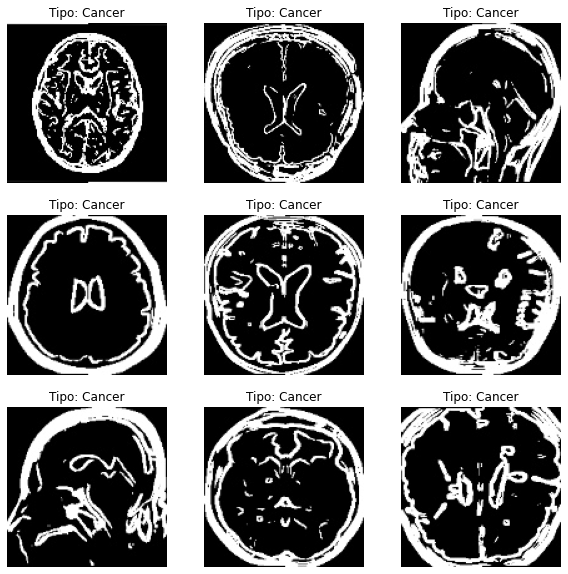

In [91]:
# extraemos un batch
ims, lab = next(train_generator)
tipo = ["Sano", "Cancer"]
plt.figure(figsize=(10, 10))
# mostramos 9 ejemplos
for i in range(9):
    plt.subplot(331+i)
    plt.imshow(ims[i], cmap="gray"); plt.axis("off"); plt.title(f"Tipo: {tipo[int(np.max(lab[i]))]}")

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_80 (Conv2D)          (None, 124, 124, 128)     3328      
                                                                 
 average_pooling2d_63 (Avera  (None, 62, 62, 128)      0         
 gePooling2D)                                                    
                                                                 
 conv2d_81 (Conv2D)          (None, 60, 60, 64)        73792     
                                                                 
 average_pooling2d_64 (Avera  (None, 30, 30, 64)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_82 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 average_pooling2d_65 (Avera  (None, 14, 14, 64)     

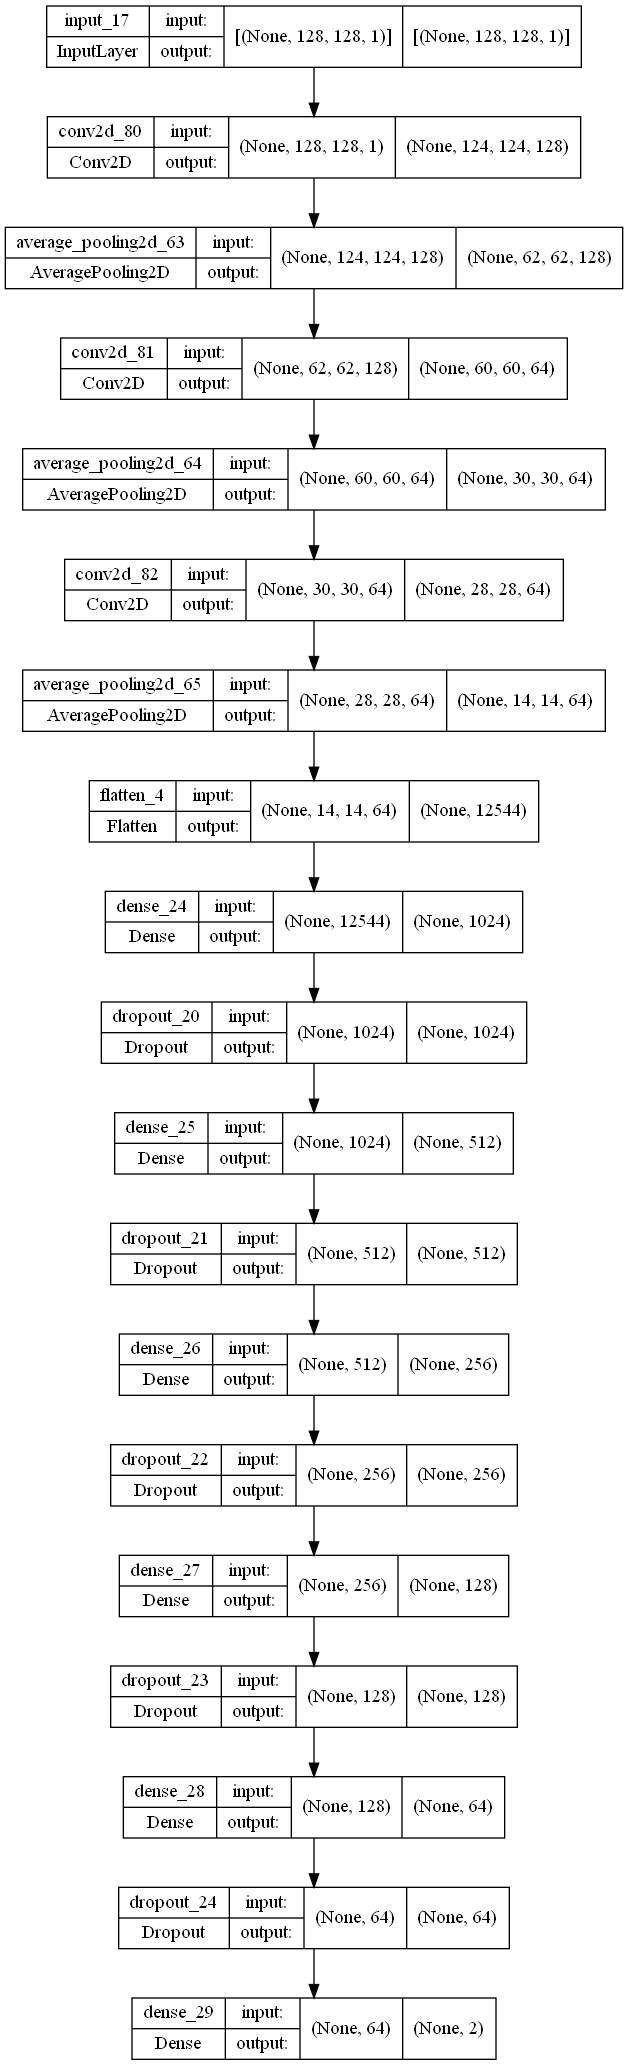

In [161]:
model = Sequential()
model.add(Input(shape=(128, 128, 1)))

model.add(Conv2D(filters=128, kernel_size=5, activation="relu"))
model.add(AveragePooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=3, activation="relu"))
model.add(AveragePooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=3, activation="relu"))
model.add(AveragePooling2D(pool_size=(2, 2)))

# Decoder
# model.add(Conv2DTranspose(128, kernel_size=5, strides=2, activation="relu", padding="same"))
# model.add(Conv2DTranspose(64, kernel_size=3, strides=2, activation="relu", padding="same"))
# model.add(Conv2DTranspose(64, kernel_size=3, strides=2, activation="relu", padding="same"))
# model.add(Conv2D(1, (3, 3), activation="sigmoid", padding="same"))


model.add(Flatten())

model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(2, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer=tf.optimizers.Adam(learning_rate=1.5e-3), metrics=["accuracy"])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [162]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min', restore_best_weights = True)

# entrenamos el modelo
history = model.fit(train_generator,
                     steps_per_epoch=train_generator.n//batch_size,  
                     epochs=100,
                     validation_data=validation_generator,
                     validation_steps=validation_generator.n//batch_size,  
                     verbose=1,
                     callbacks=[earlyStopping])
    

Epoch 1/100
25/25 [==============================] - 10s 365ms/step - loss: 0.6753 - accuracy: 0.5748 - val_loss: 0.6692 - val_accuracy: 0.6133
Epoch 2/100
25/25 [==============================] - 9s 341ms/step - loss: 0.5545 - accuracy: 0.7433 - val_loss: 0.5919 - val_accuracy: 0.7023
Epoch 3/100
25/25 [==============================] - 9s 342ms/step - loss: 0.4413 - accuracy: 0.8028 - val_loss: 0.3961 - val_accuracy: 0.8266
Epoch 4/100
25/25 [==============================] - 9s 341ms/step - loss: 0.3192 - accuracy: 0.8681 - val_loss: 0.2930 - val_accuracy: 0.8758
Epoch 5/100
25/25 [==============================] - 9s 344ms/step - loss: 0.2186 - accuracy: 0.9098 - val_loss: 0.2701 - val_accuracy: 0.8961
Epoch 6/100
25/25 [==============================] - 9s 339ms/step - loss: 0.1636 - accuracy: 0.9392 - val_loss: 0.1630 - val_accuracy: 0.9344
Epoch 7/100
25/25 [==============================] - 9s 344ms/step - loss: 0.0698 - accuracy: 0.9758 - val_loss: 0.1257 - val_accuracy: 0.960

In [165]:
[len(f[0]) for f in feature_maps][6]

12544

In [166]:
df = pd.DataFrame(columns=np.append(np.arange(12544), "type"))
for clase in ["normal", "tumor"]:
    path = 'archive/preprocess/'+clase+"/"
    for image in os.listdir(path):
        img = np.array(tf.keras.preprocessing.image.load_img(path+image, target_size=(128, 128)))
        img = tf.image.rgb_to_grayscale(img)
        img = np.expand_dims(img, axis=0)
        feature = visualization_model.predict(img)[6]
        df.loc[len(df)] = np.append(feature, clase)
df

KeyboardInterrupt: 

IndexError: index 8 is out of bounds for axis 0 with size 8

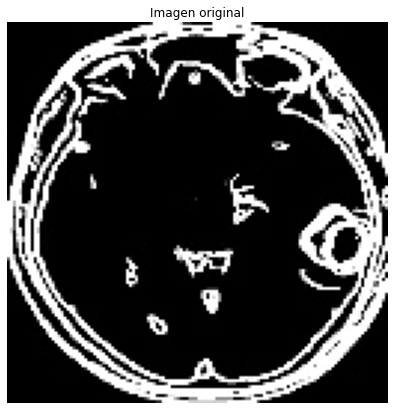

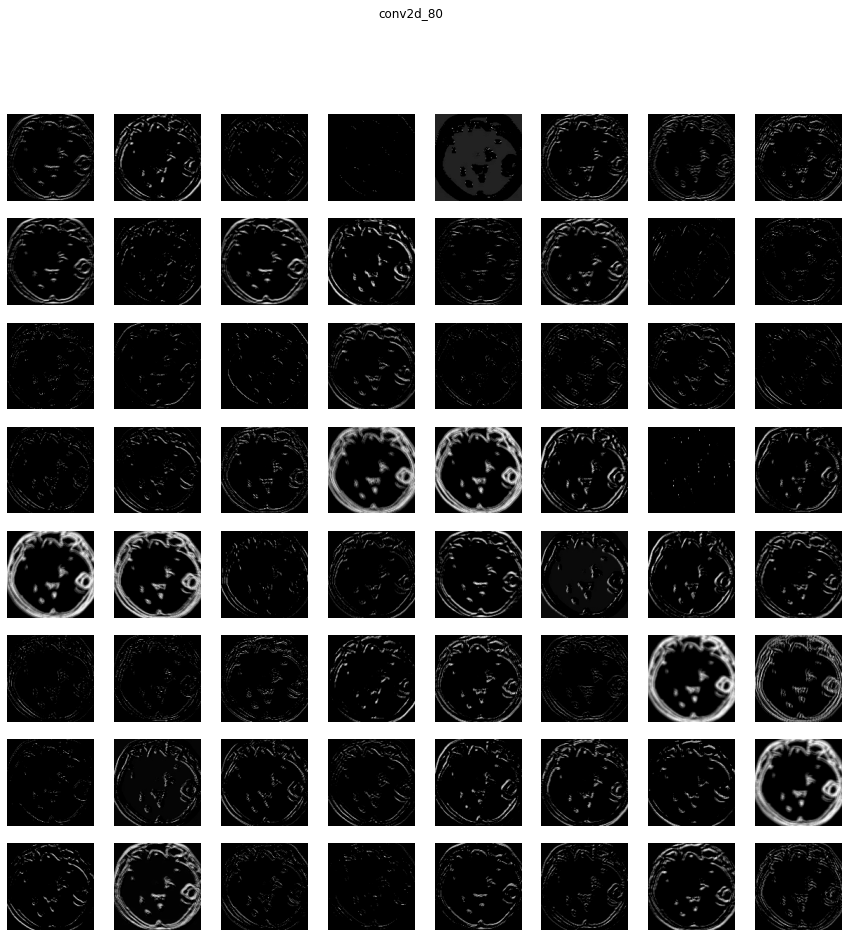

In [164]:
# Definimos un modelo que mostrará la salida de cada una de las capas de
# la red convolucional original, excepto las últimas tres (densas).
successive_outputs = [layer.output for layer in model.layers[:-3]]
visualization_model = tf.keras.models.Model(model.input, successive_outputs)

img = np.array(tf.keras.preprocessing.image.load_img("archive/preprocess/tumor/Cancer (1006).jpg", target_size=(128, 128)))
img = tf.image.rgb_to_grayscale(img)
img = np.expand_dims(img, axis=0)

# Aplicamos el preprocesamiento que usamos en el entrenamiento
img = img/255

# Obtenemos los feature maps
feature_maps = visualization_model.predict(img)
# Extraemos los nombres de cada capa
layer_names = [layer.name for layer in model.layers[:-12]]

# mostramos la imagen original
plt.figure(figsize=(7,7))
plt.imshow(img[0])
plt.axis("off")
plt.title("Imagen original")

# mostramos los feature maps:
for lab, fm in zip(layer_names, feature_maps):
    if lab == "conv2d_77" or lab =="average_pooling2d_60":
        fig, ax = plt.subplots(16, 8, figsize=(15, 15))
    else:
        fig, ax = plt.subplots(8, 8, figsize=(15, 15))
    fig.suptitle(lab)
    for filter_i in range(fm.shape[-1]):
        ax[filter_i//8, filter_i%8].imshow(fm[0,:,:,filter_i])
        ax[filter_i//8, filter_i%8].axis("off")

In [108]:
images = train_generator_tumor.next()[0]

In [98]:
predictions = model.predict(images)

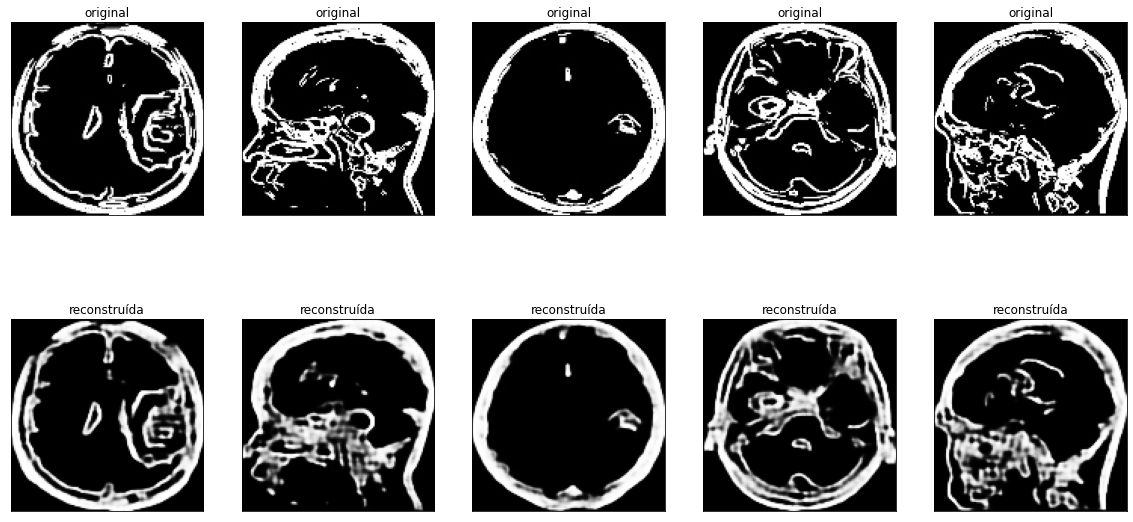

In [99]:
n = 5
plt.figure(figsize=(20, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i])
    plt.title("reconstruída")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(history.history["loss"], label="entrenamiento")
plt.plot(history.history["val_loss"], label="validación")
plt.title("Pérdida"); plt.xlabel("Época"); plt.legend()
plt.subplot(122)
plt.plot(history.history["accuracy"], label="entrenamiento")
plt.plot(history.history["val_accuracy"], label="validación")
plt.title("Accuracy"); plt.xlabel("Época"); plt.legend()

In [ ]:
print("Evaluate on validation data")
results = model1.evaluate(validation_generator, batch_size=128)
print("validation loss, validation acc:", results)

In [70]:
model1.save("modelo 9978.h5")

In [14]:
model1 = tf.keras.models.load_model("modelo 9884.h5")